# RNN - Time Series

## What is a Time Series?
A time series is a graph where historical information has been plotted and by developing a ml model we can forecast the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


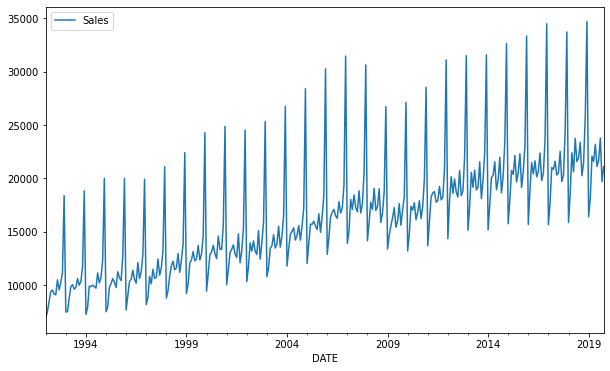

In [8]:
df.plot(figsize=(10, 6))

In [10]:
test_size = 18
test_ind = len(df) - test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

scaled_train = scaler.fit_transform(train)

scaled_test = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

The length of our batch must be less then the test set

In [20]:
len(test)

18

In [21]:
length = 12

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [23]:
n_features = 1

In [24]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [29]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [30]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0262 - val_loss: 0.0030
Epoch 2/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0215 - val_loss: 0.0202
Epoch 3/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0087 - val_loss: 0.0080


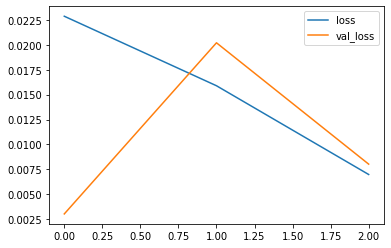

In [34]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [35]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


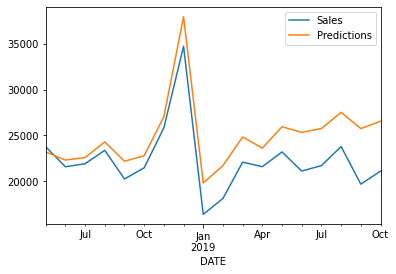

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot()

In [37]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

In [38]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [40]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
322/322 [==============================] - 2s 4ms/step - loss: 0.0370
Epoch 2/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0190
Epoch 3/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 4/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0049
Epoch 5/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0031
Epoch 6/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 7/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0026
Epoch 8/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0023


In [42]:
forecast = []

#Range must be the same as our test length - 12
periods=12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [43]:
forecast = scaler.inverse_transform(forecast)

In [44]:
forecast_index = pd.date_range(start= '2019-11-01', periods=periods, freq='MS')

In [45]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

(576.0, 602.0)

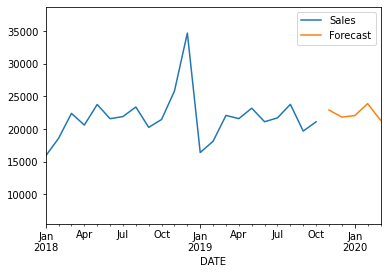

In [51]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-03-17')